In [1]:
import openpyxl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
%matplotlib inline

In [89]:
TOP = os.getcwd().replace('notebooks', '')
processed_dir = TOP + 'data/processed/'
interim_dir = TOP + 'data/interim/'
external_dir = TOP + 'data/external/'

In [208]:
df = pd.read_excel(interim_dir+'tsca_categorisation_290624_wmappingdict.xlsx', index_col = [0])

In [209]:
df.head()

,dtxsid,PREFERRED_NAME,CASRN,smiles,errors,qsar_ready_smiles,physical_form,NCC,ClassyFire,group,...,LogD55_pred,LogD55_predRange,LogD74_pred,LogD74_predRange,AD_LogD,AD_index_LogD,Conf_index_LogD,HLC,WS_pred_mol/L,WS_pred_mg/L
0,DTXSID4063036,1-Nonyne,3452-09-3,CCCCCCCC#C,NaN,CCCCCCCC#C,liquid,"('Neutral Organics',)",Acetylides,"('Acetylides', nan)",...,4.51,[4.48:4.51],4.51,[4.48:4.51],0.0,0.4990,0.4420,0.066069,6.025596e-05,7.479283
1,DTXSID30870753,1-Hexyne,693-02-7,CCCCC#C,NaN,CCCCC#C,liquid,"('Neutral Organics',)",Acetylides,"('Acetylides', nan)",...,2.73,[2.69:2.77],2.73,[2.69:2.77],0.0,0.4990,0.4470,0.112202,4.897788e-03,402.001885
2,DTXSID7062374,"1,8-Nonadiyne",2396-65-8,C#CCCCCCC#C,NaN,C#CCCCCCC#C,liquid,"('Neutral Organics',)",Acetylides,"('Acetylides', nan)",...,3.62,[3.4:3.84],3.62,[3.4:3.84],0.0,0.2950,0.3680,0.007943,1.047129e-03,125.753752
3,DTXSID9061097,1-Pentadecyne,765-13-9,CCCCCCCCCCCCCC#C,NaN,CCCCCCCCCCCCCC#C,liquid,"('Neutral Organics',)",Acetylides,"('Acetylides', nan)",...,6.61,[6.19:7.03],6.61,[6.19:7.03],0.0,0.2550,0.3525,0.001318,7.585776e-09,0.001580
4,DTXSID1061233,"1,7-Octadiyne",871-84-1,C#CCCCCC#C,NaN,C#CCCCCC#C,liquid,"('Neutral Organics',)",Acetylides,"('Acetylides', nan)",...,2.27,[1.91:2.63],2.27,[1.91:2.63],0.0,0.2895,0.3565,0.007244,3.019952e-03,320.351195


In [210]:
from sklearn.model_selection import cross_validate,KFold,ShuffleSplit
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import balanced_accuracy_score, f1_score, make_scorer, roc_auc_score
from sklearn.metrics import auc, matthews_corrcoef
from sklearn.model_selection import StratifiedKFold

from sklearn.model_selection import train_test_split
from sklearn import set_config
set_config(display = 'diagram')

In [211]:
df['group_str']=[str(e) for e in df['group'] ]

In [212]:
df1 = df.set_index('dtxsid')

In [213]:
import sys

In [214]:
LIB = TOP+'src/models/'
if not LIB in sys.path: 
    sys.path.insert(0,LIB)


In [215]:
from model_functions import *

In [216]:
data = mk_fp(df)

[16:28:41] Explicit valence for atom # 22 O, 3, is greater than permitted
[16:28:41] Explicit valence for atom # 0 O, 3, is greater than permitted
[16:28:41] SMILES Parse Error: syntax error while parsing: -
[16:28:41] SMILES Parse Error: Failed parsing SMILES '-' for input: '-'
[16:28:41] Explicit valence for atom # 1 Br, 3, is greater than permitted
[16:28:41] Explicit valence for atom # 1 Cl, 3, is greater than permitted
[16:28:41] Explicit valence for atom # 1 Cl, 7, is greater than permitted
[16:28:41] Explicit valence for atom # 5 C, 5, is greater than permitted
[16:28:41] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:28:41] Explicit valence for atom # 4 Al, 7, is greater than permitted
[16:28:41] Explicit valence for atom # 0 O, 3, is greater than permitted
[16:28:41] Explicit valence for atom # 0 O, 3, is greater than permitted
[16:28:41] Explicit valence for atom # 0 B, 6, is greater than permitted
[16:28:41] Explicit valence for atom # 1 O, 3, is greater t

In [217]:
y = df1['group_str']

In [218]:
df2 = (pd.concat([data, y], axis = 1)
       .dropna()
      )

In [219]:
from collections import Counter

In [220]:
df2['group_str'].value_counts()

group_str
('Benzene and substituted derivatives', 2.0)    562
('Benzene and substituted derivatives', 8.0)    553
('Prenol lipids', 2.0)                          509
('Fatty Acyls', 1.0)                            469
('Carboxylic acids and derivatives', 1.0)       362
                                               ... 
('Mixed metal/non-metal compounds', nan)          2
('Organic nitrogen compounds', nan)               2
('Allenes', nan)                                  2
('Pyridines and derivatives', nan)                1
('Hydrocarbons', nan)                             1
Name: count, Length: 189, dtype: int64

In [221]:
counts = Counter([molecule for molecule in df2['group_str']])

In [222]:
counts

Counter({"('Benzene and substituted derivatives', 2.0)": 562,
         "('Benzene and substituted derivatives', 8.0)": 553,
         "('Prenol lipids', 2.0)": 509,
         "('Fatty Acyls', 1.0)": 469,
         "('Carboxylic acids and derivatives', 1.0)": 362,
         "('Benzene and substituted derivatives', 10.0)": 352,
         "('Carboxylic acids and derivatives', 5.0)": 349,
         "('Organooxygen compounds', 3.0)": 324,
         "('Organooxygen compounds', 5.0)": 280,
         "('Organoheterocyclic compounds', 3.0)": 274,
         "('Organooxygen compounds', 2.0)": 273,
         "('Organometallic compounds', 2.0)": 267,
         "('Organoheterocyclic compounds', 1.0)": 265,
         "('Carboxylic acids and derivatives', 2.0)": 264,
         "('Organohalogen compounds', 2.0)": 255,
         "('Organooxygen compounds', 1.0)": 246,
         "('Benzene and substituted derivatives', 3.0)": 227,
         "('Benzene and substituted derivatives', 6.0)": 226,
         "('Benzene and sub

In [223]:
len( [group for group in counts if counts[group]>15])

151

In [224]:
small_groups = [group for group in counts if counts[group]<15]
len(small_groups)

32

In [225]:
df2['group'] = df2['group_str'].apply(lambda x: 'misc_category' if x in small_groups else x)

In [226]:
cats = set(df2['group'].sort_values().tolist())

In [227]:
my_dict = {}
sorted_cats = sorted(cats)  # Sort the categories

for i, e in enumerate(sorted_cats, 1):
    a = f'Category{i}'
    my_dict[e] = a
    

In [228]:
df2['category'] = df2['group'].replace(my_dict)

In [229]:
df2.category.value_counts()

category
Category24     562
Category30     553
Category147    509
Category51     469
Category40     362
              ... 
Category14      15
Category18      15
Category134     15
Category2       15
Category19      15
Name: count, Length: 158, dtype: int64

In [230]:
y = df2['category']

In [231]:
X = df2.drop(['group_str', 'group', 'category'], axis = 1)

In [232]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.2, random_state = 42)

In [233]:
from sklearn.feature_selection import VarianceThreshold
var_thr = VarianceThreshold(threshold = 0)

In [234]:
var_thr.fit(X_train)

VarianceThreshold(threshold=0)

In [235]:
concol = [col for col in X_train.columns if col not in X_train.columns[var_thr.get_support()]]

In [236]:
len(concol)

0

In [32]:
cv = StratifiedKFold(n_splits=5, shuffle = True, random_state = 42)

In [33]:
from sklearn.metrics import f1_score

In [34]:
scorer = lambda estimator, X, y: f1_score(y, estimator.predict(X),
                                              average='macro') 

In [35]:
rfc = RandomForestClassifier(n_estimators = 100, max_samples = 0.66, random_state = 42)

In [36]:
cv_results = cross_validate(rfc, X_train, y_train , cv=cv, scoring = scorer, return_train_score = True)

In [37]:
cv_results

{'fit_time': array([8.37508416, 8.30527711, 8.2021122 , 8.28106332, 8.54188085]),
 'score_time': array([0.22583461, 0.19306993, 0.19384837, 0.26105595, 0.24773574]),
 'test_score': array([0.63523889, 0.59719404, 0.65131745, 0.6130276 , 0.6400187 ]),
 'train_score': array([0.99467141, 0.9949858 , 0.99410344, 0.99364038, 0.99433819])}

In [38]:
cv_results = pd.DataFrame(cv_results)

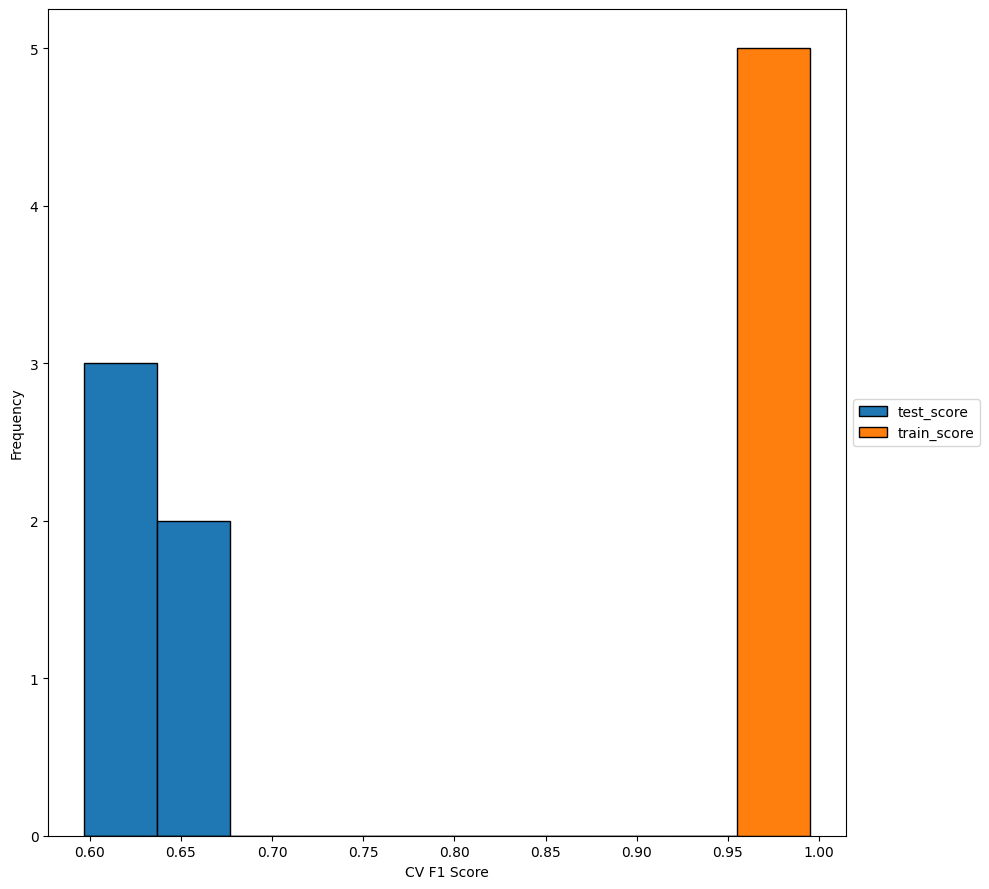

In [39]:
cv_results[['test_score', 'train_score']].plot.hist(edgecolor = 'black', figsize = (10,9))
plt.xlabel('CV F1 Score')
plt.legend(loc = 'center left', bbox_to_anchor = (1,0.5))
plt.tight_layout()

In [40]:
from sklearn.model_selection import validation_curve
rf = RandomForestClassifier(max_samples = 0.66, random_state = 42)
n_estimators = [1,5, 10, 25, 50, 75, 100, 150]
train_scores, test_scores = validation_curve(
    rf, X_train, y_train, param_name="n_estimators", param_range=n_estimators,
    cv=cv, scoring=scorer, n_jobs=2)

/home/grace/anaconda3/envs/py310/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Text(0, 0.5, 'F1 Score (mean)')

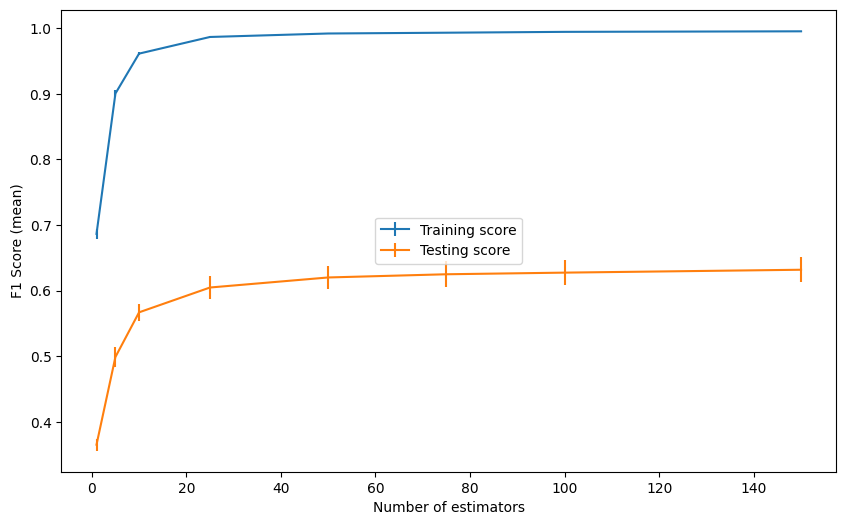

In [41]:
plt.figure(figsize = (10,6))
plt.errorbar(n_estimators, train_scores.mean(axis=1),
             yerr=train_scores.std(axis=1), label='Training score')
plt.errorbar(n_estimators, test_scores.mean(axis=1),
             yerr=test_scores.std(axis=1), label='Testing score')
plt.legend(loc = 'center')

plt.xlabel("Number of estimators")
plt.ylabel("F1 Score (mean)")

In [42]:
dummy_clf = DummyClassifier(strategy="most_frequent")

In [43]:
result_dummy = cross_validate(dummy_clf, X_train, y_train, cv=cv, scoring = scorer )

In [44]:
result_dummy

{'fit_time': array([0.08177352, 0.06114244, 0.06715727, 0.05812025, 0.05808115]),
 'score_time': array([0.00955296, 0.0173068 , 0.01153517, 0.0120883 , 0.01158118]),
 'test_score': array([0.00047656, 0.00048171, 0.00048171, 0.00048171, 0.00048171])}

In [45]:
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced','balanced_subsample', None],
    'criterion' :['gini', 'entropy'],
    'max_samples' : [0.66]
}

In [47]:
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


In [50]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [51]:
rf_classifier = RandomForestClassifier(random_state = 42 )

In [52]:
random_search = RandomizedSearchCV(estimator=rf_classifier, param_distributions=param_grid, n_iter=50,
                                   scoring=make_scorer(balanced_accuracy_score), n_jobs=-1, cv=inner_cv, random_state=42)

# Fit the random search to your data
cv_random_search = cross_validate(random_search, X_train, y_train , cv=outer_cv, scoring = scorer, return_estimator = True)



/home/grace/anaconda3/envs/py310/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/home/grace/anaconda3/envs/py310/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/home/grace/anaconda3/envs/py310/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/home/grace/anaconda3/envs/py310/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This ca

In [53]:
for estimator in cv_random_search["estimator"]:
    print(estimator.best_params_, estimator.best_score_)

{'n_estimators': 400, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_samples': 0.66, 'max_features': 'log2', 'max_depth': None, 'criterion': 'gini', 'class_weight': 'balanced_subsample'} 0.6999096465398587
{'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_samples': 0.66, 'max_features': 'log2', 'max_depth': None, 'criterion': 'gini', 'class_weight': 'balanced_subsample'} 0.7047017141403755
{'n_estimators': 400, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_samples': 0.66, 'max_features': 'log2', 'max_depth': None, 'criterion': 'gini', 'class_weight': 'balanced_subsample'} 0.6920683557737037
{'n_estimators': 400, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_samples': 0.66, 'max_features': 'log2', 'max_depth': None, 'criterion': 'gini', 'class_weight': 'balanced_subsample'} 0.7050015355534072
{'n_estimators': 400, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_samples': 0.66, 'max_features': 'log2', 'max_depth': None, 'criterion': 'gini

In [54]:
cv_random_search['test_score'].mean(), cv_random_search['test_score'].std()


(0.6633238921999064, 0.0139084692222099)

In [237]:
model = RandomForestClassifier(random_state = 42, n_estimators= 400,
 min_samples_split=10,
 min_samples_leaf= 1,
 max_features='log2',
max_samples=0.66,
 max_depth= None,
 criterion='gini',
 class_weight= 'balanced_subsample')

In [238]:
model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced_subsample', max_features='log2',
                       max_samples=0.66, min_samples_split=10, n_estimators=400,
                       random_state=42)

In [239]:
preds = model.predict(X_test)

In [240]:
balanced_accuracy_score(y_test, preds)

0.7378326475455571

In [241]:
f1_score(y_test, preds,average = 'weighted')

0.7195021155740347

In [68]:
from sklearn.metrics import recall_score, accuracy_score
unique_classes = set(y_test)

# Initialize a dictionary to store the balanced accuracy scores for each class
balanced_accuracy_scores = {}
recall_scores = {}
precision_scores = {}
# Compute balanced accuracy for each class
for cls in unique_classes:
    # Create binary labels for the current class
    y_true_cls = [1 if y == cls else 0 for y in y_test]
    y_pred_cls = [1 if y == cls else 0 for y in preds]
    
    # Compute recall (sensitivity) for the current class
    recall = recall_score(y_true_cls, y_pred_cls)
    
    # Compute specificity (true negative rate) for the current class
    tn = sum(1 for true, pred in zip(y_true_cls, y_pred_cls) if true == pred == 0)
    fp = sum(1 for true, pred in zip(y_true_cls, y_pred_cls) if true == 0 and pred == 1)
    tp = sum(1 for true, pred in zip(y_true_cls, y_pred_cls) if true == pred == 1)
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
    precision = tp/(tp+fp) if (tp + fp) != 0 else 0
    
    # Compute balanced accuracy for the current class
    balanced_accuracy = (recall + specificity) / 2
    
    # Store the balanced accuracy score for the current class
    balanced_accuracy_scores[cls] = balanced_accuracy
    recall_scores [cls] = recall
    precision_scores[cls] = precision


In [75]:
#my_dict

In [79]:
rf_cat_perf = (pd.DataFrame(list(precision_scores.items()), columns = ['cat', 'precision']).merge(pd.DataFrame(list(recall_scores.items()), columns = ['cat', 'recall']), on = 'cat').merge(pd.DataFrame(list(balanced_accuracy_scores.items()), columns = ['cat', 'BA']), on = 'cat')
.assign(terminal_category = lambda x: x['cat'].replace({v:k for k,v in my_dict.items()}))

)

In [82]:
# test set performance scores
rf_cat_perf

,cat,precision,recall,BA,terminal_category
0,Category91,0.727273,1.000000,0.998939,"('Organic nitrogen compounds', 2.0)"
1,Category148,1.000000,1.000000,1.000000,"('Pyridines and derivatives', 1.0)"
2,Category94,0.720000,0.947368,0.972445,"('Organic nitrogen compounds', 5.0)"
3,Category137,1.000000,1.000000,1.000000,"('Phenols', 2.0)"
4,Category72,0.769231,0.833333,0.916137,"('Mixed metal/non-metal compounds', 1.0)"
...,...,...,...,...,...
153,Category128,0.800000,0.571429,0.785538,"('Oxanes', nan)"
154,Category8,0.333333,0.250000,0.624648,"('Anthracenes', 8.0)"
155,Category12,0.857143,0.857143,0.928395,"('Azobenzenes', 4.0)"
156,Category36,0.636364,1.000000,0.999295,"('Benzimidazoles', nan)"


In [61]:
from sklearn.metrics import auc, matthews_corrcoef
from sklearn.metrics import confusion_matrix, classification_report

In [62]:
matthews_corrcoef(y_test, preds)

0.7258621076863297

In [65]:
#print(classification_report(y_test, preds))

Rebuild model on full dataset

In [87]:
model.fit(X, y)

RandomForestClassifier(class_weight='balanced_subsample', max_features='log2',
                       max_samples=0.66, min_samples_split=10, n_estimators=400,
                       random_state=42)

In [90]:
import pickle
filename = 'finalized_rf_model_mgrn.sav'
pickle.dump(model, open(external_dir+filename, 'wb'))

In [91]:
pickle.dump(my_dict, open(external_dir+'category_mapping_mgrn.pkl', 'wb'))

In [83]:
import urllib.request
import requests
import time
import json
import asyncio
import aiohttp

In [84]:
#df1

In [85]:
import asyncio
import aiohttp
import urllib.parse
import json
import time

import nest_asyncio
import asyncio

# Apply the fix for running inside a Jupyter notebook or an environment with an active event loop
nest_asyncio.apply()

# Function to fetch data asynchronously
async def fetch(session, url, k):
    try:
        async with session.get(url) as response:
            b = await response.json()
            return [k, b]
    except Exception as e:
        print(f"Error fetching {url}: {e}")
        return [k, None]

# Function to process the records in batches
async def main(df1, batch_size=1000, delay=0.5):
    res = []
    async with aiohttp.ClientSession() as session:
        for i in range(0, len(df1), batch_size):
            tasks = []
            batch_df = df1.iloc[i:i + batch_size]  # Slice the dataframe into batches
            
            for k, y in zip(batch_df.index, batch_df['smiles']):
                a = urllib.parse.quote(y)
                base_url = f"https://hcd.rtpnc.epa.gov/api/descriptors?smiles={a}&type=toxprints&headers=true&format=JSON"
                tasks.append(fetch(session, base_url, k))
            
            # Run the tasks for this batch
            batch_results = await asyncio.gather(*tasks)
            res.extend(batch_results)

            # Save the results after each batch to avoid memory issues
            save_results_to_file(batch_results, i)

            # Optional delay between batches to respect rate limits
            time.sleep(delay)
    
    return res

# Function to save results to file incrementally
def save_results_to_file(batch_results, batch_start):
    filename = f'results_batch_{batch_start}.json'
    with open(filename, 'w') as f:
        json.dump(batch_results, f)
    print(f"Saved {len(batch_results)} records to {filename}")

# Function to run the API access handling environments with running event loops
def run_api_access(df1, batch_size=1000, delay=0.5):
    # Check if there's an existing event loop
    try:
        loop = asyncio.get_running_loop()
    except RuntimeError:
        loop = None
    
    if loop and loop.is_running():
        # If there's a running loop, we use `create_task` to schedule the task
        res = loop.create_task(main(df1, batch_size=batch_size, delay=delay))
        return res  # You would need to await this task if inside an async function
    else:
        # If no loop is running, we can use `asyncio.run`
        res = asyncio.run(main(df1, batch_size=batch_size, delay=delay))
        return res


In [48]:
#res = await run_api_access(df1) 

In [86]:
txps = (pd.concat([pd.read_excel(processed_dir+'txps_first10000.xlsx')
 .set_index('DTXSID')
 .drop(['INPUT', 'FOUND_BY', 'PREFERRED_NAME', 'SMILES'], axis = 1),
            pd.read_excel(processed_dir+'txps_next10000.xlsx')
 .set_index('DTXSID')
 .drop(['INPUT', 'FOUND_BY', 'PREFERRED_NAME', 'SMILES'], axis = 1)]
                 )

)


In [92]:
txps.shape

(14247, 729)

In [95]:
y

dtxsid
DTXSID4063036              ('Acetylides', nan)
DTXSID30870753             ('Acetylides', nan)
DTXSID7062374              ('Acetylides', nan)
DTXSID9061097              ('Acetylides', nan)
DTXSID1061233              ('Acetylides', nan)
                              ...             
DTXSID7070391     ('Triphenyl compounds', nan)
DTXSID70889405    ('Triphenyl compounds', nan)
DTXSID90886794    ('Triphenyl compounds', nan)
DTXSID3073052     ('Triphenyl compounds', nan)
DTXSID7031531     ('Triphenyl compounds', nan)
Name: group_str, Length: 14247, dtype: object

In [96]:
df_txp = (pd.concat([txps, y], axis = 1)
       .dropna()
      )

In [97]:
df_txp.group_str.value_counts()

group_str
('Benzene and substituted derivatives', 2.0)    560
('Benzene and substituted derivatives', 8.0)    551
('Prenol lipids', 2.0)                          508
('Fatty Acyls', 1.0)                            469
('Carboxylic acids and derivatives', 1.0)       362
                                               ... 
('Inorganic salts', nan)                          2
('Benzene and substituted derivatives', nan)      2
('Allenes', nan)                                  2
('Pyridines and derivatives', nan)                1
('Organic nitrogen compounds', nan)               1
Name: count, Length: 189, dtype: int64

In [98]:
counts = Counter([molecule for molecule in df_txp['group_str']])

In [99]:
small_groups = [group for group in counts if counts[group]<15]

In [100]:
df_txp['group'] = df_txp['group_str'].apply(lambda x: 'misc_category' if x in small_groups else x)

In [101]:
df_txp['group'].value_counts()

group
('Benzene and substituted derivatives', 2.0)    560
('Benzene and substituted derivatives', 8.0)    551
('Prenol lipids', 2.0)                          508
('Fatty Acyls', 1.0)                            469
('Carboxylic acids and derivatives', 1.0)       362
                                               ... 
('Azobenzenes', 7.0)                             15
('Azoles', 7.0)                                  15
('Phenol ethers', 4.0)                           15
('Anthracenes', 1.0)                             15
('Azolidines', 2.0)                              15
Name: count, Length: 158, dtype: int64

In [102]:
cats = set(df_txp['group'].sort_values().tolist())

In [103]:
my_dict = {}
sorted_cats = sorted(cats)  # Sort the categories

for i, e in enumerate(sorted_cats, 1):
    a = f'Category{i}'
    my_dict[e] = a
    

In [104]:
df_txp['category'] = df_txp['group'].replace(my_dict)

In [105]:
df_txp.category.value_counts()

category
Category24     560
Category30     551
Category147    508
Category51     469
Category40     362
              ... 
Category14      15
Category18      15
Category134     15
Category2       15
Category19      15
Name: count, Length: 158, dtype: int64

In [106]:
df_txp.category.nunique()

158

In [107]:
y1 = df_txp['category']
X1 = df_txp.drop(['group_str', 'group', 'category'], axis = 1)
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, stratify = y1, test_size = 0.2, random_state = 42)


In [108]:
rfc = RandomForestClassifier(n_estimators = 100, max_samples = 0.66, random_state = 42)

In [109]:
cv_results1 = cross_validate(rfc, X_train1, y_train1 , cv=cv, scoring = scorer, return_train_score = True)

In [110]:
cv_results1

{'fit_time': array([5.90529633, 6.15007257, 5.66417789, 5.63996935, 6.05785418]),
 'score_time': array([0.20585012, 0.19841671, 0.19195819, 0.19455028, 0.19662786]),
 'test_score': array([0.62206268, 0.60912693, 0.60223729, 0.63226275, 0.64369635]),
 'train_score': array([0.9255752 , 0.93211185, 0.92926243, 0.92719948, 0.93233366])}

In [111]:
#performance not much better between Morgan and ToxPrints

In [112]:
cv_results1['test_score'].mean()

0.6218771996706813

In [113]:
cv_results['test_score'].mean()

0.6273593352574647

Trying a different approach

In [114]:
(df2.group_str.value_counts().reset_index()
 .query('count <15')
)

,group_str,count
157,"('Phenylpropanoids and polyketides', 1.0)",14
158,"('Organic carbonic acids and derivatives', 2.0)",14
159,"('Benzenoids', 2.0)",14
160,"('Organoheterocyclic compounds', 2.0)",14
161,"('Azoles', 6.0)",13
162,"('Azobenzenes', 5.0)",13
163,"('Azoles', 5.0)",12
164,"('Homogeneous non-metal compounds', 1.0)",11
165,"('Quinolines and derivatives', 2.0)",11
166,"('Anthracenes', 2.0)",11


In [115]:
df2['primary_category'] = [e.split(',')[0].strip("(' ").strip()  for e in df2['group_str']]

In [116]:
df2[df2['primary_category'] =='Organic 1']

,mrgn_0,mrgn_1,mrgn_2,mrgn_3,mrgn_4,mrgn_5,mrgn_6,mrgn_7,mrgn_8,mrgn_9,...,mrgn_2042,mrgn_2043,mrgn_2044,mrgn_2045,mrgn_2046,mrgn_2047,group_str,group,category,primary_category
DTXSID6052611,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"('Organic 1,3-dipolar compounds', nan)","('Organic 1,3-dipolar compounds', nan)",Category83,Organic 1
DTXSID4062228,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"('Organic 1,3-dipolar compounds', nan)","('Organic 1,3-dipolar compounds', nan)",Category83,Organic 1
DTXSID7060338,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"('Organic 1,3-dipolar compounds', nan)","('Organic 1,3-dipolar compounds', nan)",Category83,Organic 1
DTXSID4063248,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"('Organic 1,3-dipolar compounds', nan)","('Organic 1,3-dipolar compounds', nan)",Category83,Organic 1
DTXSID6020981,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"('Organic 1,3-dipolar compounds', nan)","('Organic 1,3-dipolar compounds', nan)",Category83,Organic 1
DTXSID9063409,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"('Organic 1,3-dipolar compounds', nan)","('Organic 1,3-dipolar compounds', nan)",Category83,Organic 1
DTXSID4067696,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,"('Organic 1,3-dipolar compounds', nan)","('Organic 1,3-dipolar compounds', nan)",Category83,Organic 1
DTXSID7024798,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"('Organic 1,3-dipolar compounds', nan)","('Organic 1,3-dipolar compounds', nan)",Category83,Organic 1
DTXSID1020980,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"('Organic 1,3-dipolar compounds', nan)","('Organic 1,3-dipolar compounds', nan)",Category83,Organic 1
DTXSID5041437,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"('Organic 1,3-dipolar compounds', nan)","('Organic 1,3-dipolar compounds', nan)",Category83,Organic 1


In [117]:
for index in df2.index:
    if df2.loc[index, 'primary_category'] == 'Organic 1':
        df2.loc[index,  'primary_category'] = 'Organic 1,3-dipolar compounds'

In [118]:
#df2.primary_category.unique()

In [119]:
df2['cluster_label'] = [e.split(',')[1].strip(")' ").strip()  for e in df2['group_str']]

In [121]:
#df2[df2['class_label_aggregated'] =='Organic 1,3-dipolar compounds'].head(1)

In [122]:
df2['cluster_label'].unique()

array(['nan', '1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0', '8.0',
       '9.0', '10.0', 'neolignans and related compounds', 'nucleotides',
       '3-dipolar compounds'], dtype=object)

In [123]:
df2[df2['cluster_label'] == 'nucleotides']

,mrgn_0,mrgn_1,mrgn_2,mrgn_3,mrgn_4,mrgn_5,mrgn_6,mrgn_7,mrgn_8,mrgn_9,...,mrgn_2043,mrgn_2044,mrgn_2045,mrgn_2046,mrgn_2047,group_str,group,category,primary_category,cluster_label
DTXSID60883210,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,"('Nucleosides, nucleotides, and analogues', nan)","('Nucleosides, nucleotides, and analogues', nan)",Category82,Nucleosides,nucleotides
DTXSID2045236,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,"('Nucleosides, nucleotides, and analogues', nan)","('Nucleosides, nucleotides, and analogues', nan)",Category82,Nucleosides,nucleotides
DTXSID70883620,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,"('Nucleosides, nucleotides, and analogues', nan)","('Nucleosides, nucleotides, and analogues', nan)",Category82,Nucleosides,nucleotides
DTXSID40891555,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,"('Nucleosides, nucleotides, and analogues', nan)","('Nucleosides, nucleotides, and analogues', nan)",Category82,Nucleosides,nucleotides
DTXSID50889322,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,"('Nucleosides, nucleotides, and analogues', nan)","('Nucleosides, nucleotides, and analogues', nan)",Category82,Nucleosides,nucleotides
DTXSID5023661,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,"('Nucleosides, nucleotides, and analogues', nan)","('Nucleosides, nucleotides, and analogues', nan)",Category82,Nucleosides,nucleotides
DTXSID8040436,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,"('Nucleosides, nucleotides, and analogues', nan)","('Nucleosides, nucleotides, and analogues', nan)",Category82,Nucleosides,nucleotides
DTXSID30883621,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,"('Nucleosides, nucleotides, and analogues', nan)","('Nucleosides, nucleotides, and analogues', nan)",Category82,Nucleosides,nucleotides
DTXSID00893055,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,"('Nucleosides, nucleotides, and analogues', nan)","('Nucleosides, nucleotides, and analogues', nan)",Category82,Nucleosides,nucleotides
DTXSID1022558,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,"('Nucleosides, nucleotides, and analogues', nan)","('Nucleosides, nucleotides, and analogues', nan)",Category82,Nucleosides,nucleotides


In [124]:
for index in df2.index:
    if df2.loc[index, 'primary_category'] == 'Nucleosides':
        df2.loc[index,  'primary_category'] = 'Nucleosides, nucleotides, and analogues'

In [125]:
for index in df2.index:
    if df2.loc[index, 'cluster_label'] == 'nucleotides':
        df2.loc[index,  'cluster_label'] = np.nan

In [126]:
for index in df2.index:
    if df2.loc[index, 'primary_category'] == 'Lignans':
        df2.loc[index,  'primary_category'] = 'Lignans, neolignans and related compounds'

In [127]:
for index in df2.index:
    if df2.loc[index, 'cluster_label'] == 'neolignans and related compounds':
        df2.loc[index,  'cluster_label'] = np.nan

In [128]:
for index in df2.index:
    if df2.loc[index, 'primary_category'] == 'Organic 1,3-dipolar compounds':
        df2.loc[index,  'cluster_label'] = np.nan

In [129]:
(np.percentile(df2.primary_category.value_counts().values, 12)
 
)

30.04

In [130]:
def ecdf(data):
    '''
    Calculate the ecdf of a 1d-array
    Returns the x, y needed to plot the empirical ecdf
    '''
    n = len(data)
    x = np.sort(data)
    y = np.arange(1, n+1)/n
    return x, y
    

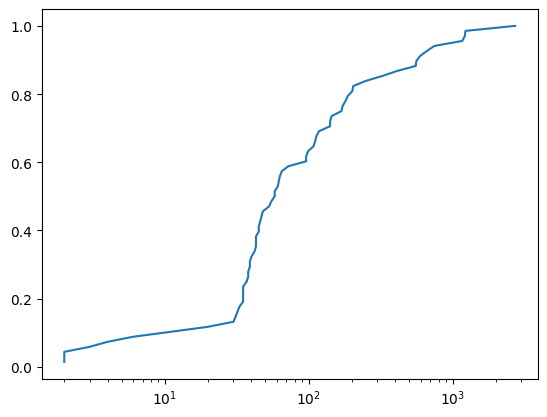

In [131]:
plt.xscale('log')
plt.plot(ecdf(df2.primary_category.value_counts())[0], ecdf(df2.primary_category.value_counts())[1], marker = ',', linestyle = None)

In [132]:
thres = (df2.primary_category.value_counts().reset_index()
 .query('count <=30')
 .primary_category.tolist()
         + ['Other']
)

In [133]:
df2['class_label_aggregated'] = df2['primary_category'].apply(lambda x: 'misc' if x in thres else x)


In [134]:
#df2.class_label_aggregated.value_counts().plot.barh(figsize = (6,15))

In [135]:
y_class = df2['class_label_aggregated']


In [136]:
df2['cluster_label'] = (pd.to_numeric(df2.cluster_label, errors = 'coerce').replace(np.nan, 9999)

)

In [137]:
df2.cluster_label.value_counts(dropna = False)

cluster_label
2.0       3115
1.0       2469
3.0       2208
4.0       1611
9999.0    1448
5.0       1410
6.0        622
8.0        575
10.0       352
7.0        207
9.0        202
Name: count, dtype: int64

In [138]:
X = df2.drop(['group_str',
       'group', 'category', 'primary_category', 'cluster_label',
       'class_label_aggregated'], axis = 1)

In [139]:
X_train, X_test, y_train_class, y_test_class = train_test_split(X, y_class, stratify=y_class, test_size=0.2, random_state=42)

# Train Random Forest for chemical class
rf_class = RandomForestClassifier(class_weight='balanced', random_state=42)

In [140]:
cv_results2 = cross_validate(rf_class, X_train, y_train_class , cv=cv, scoring = scorer, return_train_score = True)

In [145]:
cv_results2['test_score'].mean()

0.6526863303299008

In [142]:
cluster_models = {}

for class_label in df2['class_label_aggregated'].unique():
    class_data = df2[df2['class_label_aggregated'] == class_label]
    
    if (class_data['cluster_label'].value_counts() >=2).all():    # Train if there are multiple clusters within the class
        X_train_class, X_test_class, y_train_cluster, y_test_cluster = train_test_split(
            class_data.drop(['group_str',
       'group', 'category', 'primary_category', 'cluster_label',
       'class_label_aggregated'], axis = 1), class_data['cluster_label'], stratify=class_data['cluster_label'], test_size=0.2, random_state=42)
        
        # Train Random Forest for cluster IDs within the class
        rf_cluster = RandomForestClassifier(class_weight='balanced', random_state=42)
        rf_cluster_cv = cross_validate(rf_class, X_train_class, y_train_cluster , cv=cv, scoring = scorer, return_train_score = True)
        # Store the model for this specific chemical class
        cluster_models[class_label] = rf_cluster_cv['test_score']

/home/grace/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/grace/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/grace/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/grace/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/grace/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has

In [144]:
#cluster_models

In [146]:
rf_class = RandomForestClassifier(class_weight='balanced', random_state=42)

In [147]:
rf_class.fit(X_train, y_train_class)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [148]:
class_model = rf_class

In [149]:
cluster_models = {}

for class_label in df2['class_label_aggregated'].unique():
    class_data = df2[df2['class_label_aggregated'] == class_label]
    
    if (class_data['cluster_label'].value_counts() >=2).all():    # Train if there are multiple clusters within the class
        X_train_class, X_test_class, y_train_cluster, y_test_cluster = train_test_split(
            class_data.drop(['group_str',
       'group', 'category', 'primary_category', 'cluster_label',
       'class_label_aggregated'], axis = 1), class_data['cluster_label'], stratify=class_data['cluster_label'], test_size=0.2, random_state=42)
        
        # Train Random Forest for cluster IDs within the class
        rf_cluster = RandomForestClassifier(class_weight='balanced', random_state=42)
        rf_cluster.fit(X_train_class, y_train_cluster )
        # Store the model for this specific chemical class
        cluster_models[class_label] = rf_cluster

In [168]:
y_test_ids = y_test_class.index.tolist()

In [171]:
y_test_ids[:5]

['DTXSID60888669',
 'DTXSID4025741',
 'DTXSID4073099',
 'DTXSID4066755',
 'DTXSID80865816']

In [173]:
df2_test = df2[df2.index.isin(y_test_ids)].reindex(y_test_ids)

In [178]:
def stacked_prediction(row, class_model, cluster_models, feature_columns):
    """
    Function to first predict the chemical class and then predict the cluster
    using the class-specific model.
    """
    # Extract features from the row
    features = row[feature_columns].values.reshape(1, -1)
    
    # Predict the chemical class using the class model
    predicted_class = class_model.predict(features)[0]
    
    # Check if there is a model available for the predicted class
    if predicted_class in cluster_models:
        # Predict the cluster using the class-specific cluster model
        cluster_model = cluster_models[predicted_class]
        predicted_cluster = cluster_model.predict(features)[0]
    else:
        predicted_cluster = 'Other'  # Handle cases where no model is available
    
    return predicted_class, predicted_cluster

# Step 4: Apply the function to your test set



In [179]:
# Define the feature columns (the same as what you used for training)
feature_columns = df2_test.drop(['group_str', 'group', 'category', 'primary_category', 'cluster_label', 'class_label_aggregated'], axis=1).columns

# Apply the stacked prediction to each row in the test set
pred_cats = []
for idx, row in df2_test.iterrows():
    predicted_class, predicted_cluster = stacked_prediction(row, class_model, cluster_models, feature_columns)
    pred_cats.append([predicted_class, predicted_cluster])


/home/grace/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/grace/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/grace/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/grace/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/grace/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted w

In [181]:
len(pred_cats)

2844

In [183]:
df2_test.shape

(2844, 2054)

In [192]:
pred_df = (pd.concat([pd.DataFrame(pred_cats, index = df2_test.index, columns = ['primary_category_pred', 'cluster_label_pred']), df2_test[['group_str',
        'primary_category', 'cluster_label',
       'class_label_aggregated']]], axis = 1)
)
 

In [196]:
pred_df = (pred_df
 .assign(both_match = (
     (pred_df['primary_category_pred'] == pred_df['primary_category'] ) &
      (pred_df['cluster_label_pred'] == pred_df['cluster_label'] ) )
        )
 
)

In [197]:
from sklearn.metrics import f1_score

In [199]:
(print(f1_score(pred_df['primary_category'], pred_df['primary_category_pred'], average='weighted'),
      
      )
)

0.7754786459842029
